# Neural Machine Translation with Attention

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata
import matplotlib.ticker as ticker

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

2024-04-03 09:58:49.261160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 09:58:49.261188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 09:58:49.262052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


- Mark, Nonspacing (Mn): In Unicode, characters can have different categories assigned to them based on their properties. "Mark, Nonspacing" (Mn) refers to a category of characters that are typically diacritics or accents that are intended to be combined with other characters but don't take up space by themselves when displayed. For example, in the word "café," the accent mark over the letter "e" is a diacritic that falls into the "Mark, Nonspacing" category in Unicode.

In [2]:
def unicode_to_ascii(w):
    return ''.join([x for x in unicodedata.normalize('NFD', w) if unicodedata.category(x) != 'Mn'])
 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub('([?!.(),¿])', r' \1', w)
    w = re.sub('\s{2,}', ' ', w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w) # This replaces everything with space
    w = w.rstrip().strip()
    return '<start> ' + w + ' <end>' 

In [3]:
def create_dataset(file_path, num_examples=None):
    spa_en = []
    cnt = 0
    with open(file_path, 'r') as file:
        for line in file.readlines():
            if num_examples is not None and cnt >= num_examples: break
            line = line.split('\t')[:2]
            spa_en.append([preprocess_sentence(line[0]), preprocess_sentence(line[1])])
            cnt += 1
    return zip(*spa_en)

In [4]:
FILE_PATH =  './temp/spa-eng/spa.txt'
en, sp = create_dataset(FILE_PATH)
print(en[-1])
print(sp[-1])

<start> one day , i woke up to find that god had put hair on my face . i shaved it off . the next day , i found that god had put it back on my face , so i shaved it off again . on the third day , when i found that god had put hair back on my face again , i decided to let god have his way . that s why i have a beard . <end>
<start> un dia , me desperte y vi que dios me habia puesto pelo en la cara . me lo afeite . al dia siguiente , vi que dios me lo habia vuelto a poner en la cara , asi que me lo afeite otra vez . al tercer dia , cuando vi que dios me habia puesto pelo en la cara de nuevo , decidi que dios se saliera con la suya . por eso tengo barba . <end>


In [5]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [6]:
def tokenize(tensor):
    lang_tokenizer = Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(tensor)
    tensor = lang_tokenizer.texts_to_sequences(tensor)
    tensor = pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [7]:
def load_dataset(file_name, num_examples=None):
    src_lang, targ_lang = create_dataset(file_name, num_examples)
    src_tensor, src_tokenizer = tokenize(src_lang)
    targ_tensor, targ_tokenizer = tokenize(targ_lang)
    return src_tensor, targ_tensor, src_tokenizer, targ_tokenizer

## Loading the dataset

In [8]:
NUM_SAMPLES = 100000
src_tensor, targ_tensor, src_tokenizer, targ_tokenizer = load_dataset(FILE_PATH, num_examples=NUM_SAMPLES)

MAX_SRC_LENGTH, MAX_TARGET_LENGTH = max_length(src_tensor), max_length(targ_tensor)
print(f'Maximum length of English sentence is {MAX_SRC_LENGTH}\nMaximum length for spanish sentence is {MAX_TARGET_LENGTH}')

Maximum length of English sentence is 15
Maximum length for spanish sentence is 22


In [9]:
src_train, src_val, targ_train, targ_val = train_test_split(src_tensor, targ_tensor, test_size=0.2)

print('Source Train shape:', src_train.shape)
print('Source Validation shape:', src_val.shape)
print('Target Train shape:', targ_train.shape)
print('Target Validation shape:', targ_val.shape)

Source Train shape: (80000, 15)
Source Validation shape: (20000, 15)
Target Train shape: (80000, 22)
Target Validation shape: (20000, 22)


In [10]:
def ids_to_text(ids, lang):
    return ' '.join(lang.index_word[i] for i in ids if i != 0)

In [11]:
i = 3000
print('Training Example (English)')
print(ids_to_text(src_train[i], src_tokenizer))

print('Training Example (Spanish)')
print(ids_to_text(targ_train[i], targ_tokenizer))

Training Example (English)
<start> can he play the guitar ? <end>
Training Example (Spanish)
<start> ¿puede el tocar la guitarra ? <end>


## Create the pipeline

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ENC_UNITS = 512
DEC_UNITS = 1024
EMBEDDING_DIM = 256
VOCAB_SRC_SIZE = len(src_tokenizer.index_word) + 1
VOCAB_TARG_SIZE = len(targ_tokenizer.index_word) + 1
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(src_train) // BATCH_SIZE
BUFFER_SIZE = len(src_train)

train_ds = tf.data.Dataset.from_tensor_slices((src_train, targ_train))
train_ds = train_ds.shuffle(BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((src_val, targ_val))
test_ds = test_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
test_ds = test_ds.prefetch(AUTOTUNE)

In [13]:
example_train_source, example_train_target = next(iter(train_ds))
print('Example Train Source:', example_train_source.shape)
print('Example Train Target:', example_train_target.shape)

Example Train Source: (64, 15)
Example Train Target: (64, 22)


## Define model

In [14]:
from keras.layers import Layer, Dense, Activation, GRU, Bidirectional, Embedding
from keras.models import Model

In [15]:
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.enc_units = enc_units
        self.batch_size = batch_size

        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        
        self.gru = Bidirectional(GRU(
            units=self.enc_units,
            return_sequences=True, 
            return_state=True
        ))

        self.reset_hidden_states()

    def call(self, inputs, hidden=None):
        if hidden is not None:
            self._hidden = hidden[0]
            self._backward_hidden = hidden[1]
            
        embedding = self.embedding(inputs)
        sequences, h, bh = self.gru(embedding, initial_state=(self._hidden, self._backward_hidden))
        return sequences, (h, bh)

    def reset_hidden_states(self):
        self._hidden = tf.zeros((self.batch_size, self.enc_units))
        self._backward_hidden = tf.zeros((self.batch_size, self.enc_units))

    
    def get_hidden_states(self):
        return self._hidden, self._backward_hidden


In [16]:
encoder = Encoder(VOCAB_SRC_SIZE, EMBEDDING_DIM, ENC_UNITS, BATCH_SIZE)
sample_sequence, sample_hidden = encoder(example_train_source)
print('Output sequence shape:', sample_sequence.shape)
print('State shape for both forward and backward:', sample_hidden[0].shape)

Output sequence shape: (64, 15, 1024)
State shape for both forward and backward: (64, 512)


In [17]:
class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.Wa = Dense(units)
        self.Ua = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):
        """
        args:
            query is the previous state of the decoder i.e. s_{i-1}, the shape is (batches, decoder_units)
            values are the output sequences from the decoder, the shape if (batches, max_src_length, encoder_units)
        returns:
        """
        # Let's add time dimension to query to have the shape (batches, 1, units)
        query_with_time = tf.expand_dims(query, axis=1)

        # Given Wa, the query, it computes a mapping with the shape of (batches, 1, units) 
        # Given Ua, the values, it computes a mapping with the shape of (batches, max_src_length, units)
        # Note that adding these two is possible only when the result of Wa is broadcasted to have (batches, max_src_length, units)
        # Give the resulting (batches, max_src_length, units) to V, it will compute scores with the shape of (batches, max_src_length, 1)
        scores = self.V(tf.nn.tanh(self.Wa(query_with_time) + self.Ua(values)))

        # attention_weights has the shape (batches, max_src_length, 1)
        attention_weights = tf.nn.softmax(scores, axis=1)

        # attention weights are broadcasted to be able to multiply it by values with shape of (batches, max_src_length, encoder_units)
        context_vector = attention_weights * values
        # context vector will be expected annotation over all the annotations with the shape (batches, encoder_units)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [18]:
attention = BahdanauAttention(units=10)
s_prev = tf.zeros((BATCH_SIZE, DEC_UNITS))
context_vector, attention_weights = attention(s_prev, sample_sequence)
print('Context vector\'s shape is', context_vector.shape)
print('Attention_weights\' shape is', attention_weights.shape)

Context vector's shape is (64, 1024)
Attention_weights' shape is (64, 15, 1)


In [19]:
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.dec_units = dec_units
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim

        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.gru = GRU(units=dec_units, return_state=True, return_sequences=True)
        self.attention = BahdanauAttention(dec_units)
        self.fc = Dense(units=vocab_size)

        self.reset_states()
    def call(self, inputs, enc_output, hidden_state=None):
        # note that inputs have the shape (batch_size, 1)
        if hidden_state is not None:
            self._hidden_state = hidden_state

        context_vector, attention_weights = self.attention(self._hidden_state, enc_output)

        # embeddings will have the shape (batch_size, 1, embedding_dim)
        embeddings = self.embedding(inputs)
        
        # Add time-step dimension for the context_vector to have (batch, 1, enc_units)
        context_vector = tf.expand_dims(context_vector, 1)
        
        # Concat context and embeddings
        # Should result in (batch, 1, enc_units + embedding_dim)
        x = tf.concat([context_vector, embeddings], axis=-1)

        # outputs shape will be (batch, 1, dec_units)
        outputs, states = self.gru(x)

        # outputs shape will be (batch * 1, dec_units) 
        outputs = tf.reshape(outputs, (-1, outputs.shape[2]))

        # resulting outputs will have the shape (batch, target_vocab_size)
        outputs = self.fc(outputs)
        return outputs, states, attention_weights

    def reset_states(self):
        self._hidden_state = tf.zeros((self.batch_size, self.dec_units))

In [20]:
decoder = Decoder(VOCAB_TARG_SIZE, EMBEDDING_DIM, DEC_UNITS, BATCH_SIZE)
hidden = tf.concat([sample_hidden[0], sample_hidden[1]], axis=-1)
outputs , _, _ = decoder(tf.zeros(shape=(BATCH_SIZE, 1)), sample_sequence, hidden_state=hidden)
print('Decoder outputs shape is', outputs.shape)

Decoder outputs shape is (64, 20468)


## Define the optimizer and Loss function

In [21]:
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

In [22]:
loss_object = SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam()

def loss_function(real, pred):
    # Make a mask that is 1 everywhere there is not a padding, and 0 for paddings
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [23]:
@tf.function
def train_step(inp, targ, hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, (enc_h, enc_bh) = encoder(inp, hidden)
        dec_hidden = tf.concat([enc_h, enc_bh], axis=-1)
        dec_inputs = tf.expand_dims([targ_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            dec_outputs, dec_hidden, _ = decoder(dec_inputs, enc_output, dec_hidden)
            computed_loss = loss_function(targ[:, t], dec_outputs)
            loss = loss + computed_loss
            dec_inputs = tf.expand_dims(targ[:, t], 1)

    batch_loss = loss / int(targ.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return batch_loss

In [24]:
EPOCHS = 10
for epoch in range(EPOCHS):
    encoder.reset_hidden_states()
    enc_hidden, enc_backward_hidden = encoder.get_hidden_states()
    total_loss = 0

    print(f'Epoch {epoch + 1:>3}')
    for batch, (inp, tar) in enumerate(train_ds):
        batch_loss = train_step(inp, tar, (enc_hidden, enc_backward_hidden))
        total_loss += batch_loss.numpy()
        print(f'\rStep {batch:>5} Total Loss {batch_loss.numpy():>5.3f}', end='')
    print()

Epoch   1


I0000 00:00:1712125762.665667   31682 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step  1249 Total Loss 0.780
Epoch   2
Step  1249 Total Loss 0.668
Epoch   3
Step  1249 Total Loss 0.449
Epoch   4
Step  1249 Total Loss 0.315
Epoch   5
Step  1249 Total Loss 0.226
Epoch   6
Step  1249 Total Loss 0.167
Epoch   7
Step  1249 Total Loss 0.153
Epoch   8
Step  1249 Total Loss 0.121
Epoch   9
Step  1249 Total Loss 0.093
Epoch  10
Step  1249 Total Loss 0.086


## Prediction

In [25]:
def predict(sentence):
    attention_mtrx = np.zeros((MAX_TARGET_LENGTH, MAX_SRC_LENGTH))

    sentence = preprocess_sentence(sentence)
    src = [src_tokenizer.word_index[x] for x in sentence.split(' ')]
    src = pad_sequences([src], maxlen=MAX_SRC_LENGTH, padding='post')
    src = tf.convert_to_tensor(src)

    hidden = tf.zeros(shape=(1, ENC_UNITS), dtype=tf.float32)
    enc_out, (enc_hidden, enc_backward_hidden) = encoder(src, hidden=(hidden, hidden))

    dec_hidden = tf.concat([enc_hidden, enc_backward_hidden], axis=-1)
    target_input = tf.expand_dims([targ_tokenizer.word_index['<start>']], 0)
    result = ''

    for t in range(MAX_TARGET_LENGTH):
        predictions, dec_hidden, computed_attention = decoder(target_input, enc_out, dec_hidden)

        computed_attention = tf.reshape(computed_attention, shape=(-1))
        attention_mtrx[t] = computed_attention.numpy()

        y = tf.argmax(predictions[0]).numpy()
        result += targ_tokenizer.index_word[y] + ' '

        if targ_tokenizer.word_index['<end>'] == y:
            return result, sentence, attention_mtrx

        target_input = tf.expand_dims([y], 0)

    return result, sentence, attention_mtrx

In [26]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    plt.show()

In [27]:
def translate(sentence):
    result, sentence, attention_plot = predict(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))   
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> i love to speak in english <end>
Predicted translation: me encanta hablar en ingles . <end> 


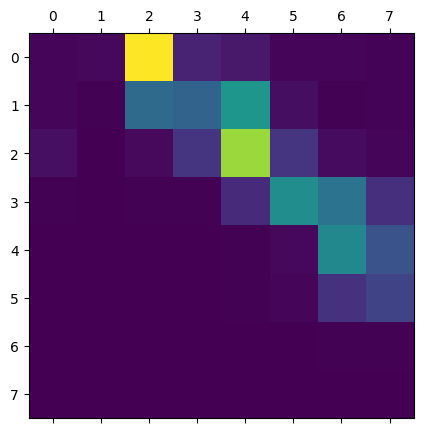

In [32]:
translate('i love to speak in English')